<a href="https://colab.research.google.com/github/DyanielCX/DLI-Assm/blob/main/GroupZ_Model_Compilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Import All Dependencies & Libraries

In [ ]:
%pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.6 MB/s eta 0:00:00


In [ ]:
import time, os, json, random
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path

# Scikit-learn Module
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer
from scipy.stats import mode

# Matploylib Module
from matplotlib import colormaps
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt


# TensorFlow Module
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import (
    Input, Embedding, SimpleRNN, Dense,
    Conv1D, GlobalMaxPooling1D, Dropout, Concatenate
)

import seaborn as sns

# Data Loading

In [ ]:
# Importing the dataset from GitHub
github_csv_url = 'https://raw.githubusercontent.com/DyanielCX/DLI-Assm/refs/heads/main/dataset_B_05_2020_1.csv'
raw_dataset = pd.read_csv(github_csv_url)

{"raw_dataset_shape": raw_dataset.shape}

{'raw_dataset_shape': (11430, 89)}

In [ ]:
display(raw_dataset.head(20))

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,1,0,1,1,4,0
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,1
2,https://support0appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,1
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,1,107721,0,0,3,0
4,http://www.iracing.com/tracks/gateway0motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,0
5,http://appleid.apple.com0app.es/,32,24,0,3,1,0,0,0,0,...,1,1,1,0,1,0,0,1,0,1
6,http://www.mutuo.it,19,12,0,2,0,0,0,0,0,...,0,1,0,170,7529,0,0,0,1,0
7,http://www.shadetreetechnology.com/V4/validati...,81,27,1,2,0,0,0,0,0,...,1,0,0,76,5767,0,0,1,2,1
8,http://vamoaestudiarmedicina.blogspot.com/,42,34,0,2,0,0,0,0,0,...,1,1,0,371,7298,0,0,0,5,0
9,https://parade.com/425836/joshwigler/the0amazi...,104,10,0,1,10,0,0,0,0,...,1,0,0,128,9368,6774,0,0,5,0


# Data Pre-pocessing

In [ ]:
''' Dataset for Deep Learning '''
# Copy the raw dataset with only 'url' and 'status' columns
DL_dataset = raw_dataset[['url', 'status']].copy()
DL_dataset['url'] = DL_dataset['url'].str.lower()

# Encode status column
label_encoder = LabelEncoder()
DL_dataset['status'] = label_encoder.fit_transform(DL_dataset['status'])

# Tokenize URLs for RNN
urls = DL_dataset['url'].astype(str).values
labels = DL_dataset['status'].values

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)
max_len = 200
X_padded = pad_sequences(sequences, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

# Keep text + label for DL
df = raw_dataset[["url", "status"]].dropna().copy()
df["url"] = df["url"].astype(str).str.lower()
y = df["status"].astype(int).values
texts = df["url"].tolist()

''' Dataset for Machine Learning '''
# Copy the raw dataset
ML_dataset = raw_dataset.copy()

# Drop the URL columns (ML only need numeric vectors data)
if 'url' in ML_dataset.columns:
    ML_dataset = ML_dataset.drop(columns=['url'])

# Model Used





*   **Dyaniel** -> Recurrent Nueral Network (RNN) + Cluster Labeling K-Means (CL K-Means)
*   **Ho Feng Sheng** -> Convolutional Nueral Network (CNN) + Support Vector Machine (SVM)
*   **Lee Zhen Yong** -> Convolutional Nueral Network (CNN) + Logistic Regression model (LR)
*   **Lee Guo Xi** -> Long Short-Term Memory (LSTM)

# Model Training

## Dyaniel Model Training (RNN + CL K-Means)

### 1. RNN Deep Learning Model

In [ ]:
# Set start time for recording the model training time
dy_train_start_time = time.time()

# Set a random seed for reproducibility
np.random.seed(42)

# Train/test split
dy_X_train, dy_X_test, dy_y_train, dy_y_test = train_test_split(
    X_padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build RNN model
input_layer = Input(shape=(max_len,))
embedding = Embedding(input_dim=vocab_size, output_dim=32)(input_layer)
rnn_output = SimpleRNN(64, return_sequences=False, name="rnn_features")(embedding)
output = Dense(1, activation='sigmoid')(rnn_output)

RNN_model = Model(inputs=input_layer, outputs=output)
RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train RNN with custom settings
RNN_model.fit(
    dy_X_train,
    dy_y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.6658 - loss: 0.6008 - val_accuracy: 0.7791 - val_loss: 0.4884
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.8175 - loss: 0.4126 - val_accuracy: 0.8431 - val_loss: 0.3692
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.8438 - loss: 0.3659 - val_accuracy: 0.8611 - val_loss: 0.3307
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8636 - loss: 0.3315 - val_accuracy: 0.8568 - val_loss: 0.3175
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8826 - loss: 0.2929 - val_accuracy: 0.8600 - val_loss: 0.3231
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8760 - loss: 0.3099 - val_accuracy: 0.8677 - val_loss: 0.3190
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.8750 - loss: 0.2980 - val_accuracy: 0.8600 - val_loss: 0.3372
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8882 - loss: 0.2814 -

### 2. Extract RNN Features & Merge with ML_Dataset

In [ ]:
# Create a new model that outputs the RNN layer
feature_extractor = Model(
    inputs=RNN_model.input,
    outputs=RNN_model.get_layer("rnn_features").output  # 'rnn_features' is the layer name
)

try:
    # Apply it on the full padded URL input
    rnn_features = feature_extractor.predict(X_padded)

    # Convert to DataFrame
    rnn_feature_df = pd.DataFrame(
        rnn_features,
        columns=[f"rnn_feat_{i}" for i in range(rnn_features.shape[1])]
    )
except Exception as e:
    print(f"❌ An error occurred during RNN feature extraction: {e}")
finally:
    print("✅ RNN feature extraction process done.")


try:
  # Drop "status" column and reset index
  ml_only = ML_dataset.drop(columns=['status']).reset_index(drop=True)

  # Standardize ML features
  scaler = StandardScaler()
  ml_scaled = scaler.fit_transform(ml_only)
  ml_scaled_df = pd.DataFrame(ml_scaled, columns=ml_only.columns)

  # Combine with RNN features
  combined_features = pd.concat([ml_scaled_df, rnn_feature_df], axis=1)

  # Reattach "status" column
  ML_combined_dataset = combined_features.copy()
  ML_combined_dataset['status'] = ML_dataset['status'].reset_index(drop=True)

except Exception as e:
    print(f"❌ An error occurred during ML dataset merging: {e}")
finally:
    print("✅ ML dataset merging done.")
    print("Final merged and scaled dataset shape:", ML_dataset.shape)

358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
✅ RNN feature extraction process done.
✅ ML dataset merging done.
Final merged and scaled dataset shape: (11430, 88)


### 3. CL_K-Means Machine Learning

In [ ]:
X = ML_combined_dataset.drop(columns=['status'])
y = ML_combined_dataset['status']

# Find the Best k using BO-TPE (Bayesian Optimization)
search_space = {'n_clusters': Integer(2, 10)}
opt_kmeans = BayesSearchCV(KMeans(random_state=42), search_space, n_iter=10, cv=3, scoring='accuracy', verbose=0)
opt_kmeans.fit(X, y)
best_k = opt_kmeans.best_params_['n_clusters']
print(f"✅ Best k found by BO-TPE: {best_k}")

# Train CL-KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X)

# Map clusters to true labels using majority voting
mapped_labels = np.zeros_like(clusters)
for i in range(best_k):
    mask = (clusters == i)
    mapped_labels[mask] = mode(y[mask])[0]

# Train Random Forest for Bias Correction
dy2_X_train, dy2_X_test, dy2_y_train, dy2_y_test = train_test_split(X, mapped_labels, test_size=0.2, stratify=y, random_state=42)
bias_corrector = RandomForestClassifier(random_state=42)
bias_corrector.fit(dy2_X_train, dy2_y_train)

# Get the model training time
dy_training_time = time.time() - dy_train_start_time
dy_training_time = round(dy_training_time / 60, 4)

✅ Best k found by BO-TPE: 2


## Ho Feng Sheng Model Training (CNN + SVM)

### 1. Train CNN to Learn from URL

In [ ]:
# Set start time for recording the model training time
js_train_start_time = time.time()

# Set a random seed for reproducibility
np.random.seed(42)

# CNN architecture
input_layer = Input(shape=(200,))
embedding = Embedding(input_dim=vocab_size, output_dim=128)(input_layer)
conv = Conv1D(filters=256, kernel_size=5, activation='relu')(embedding)
drop = Dropout(0.3)(conv)
pool = GlobalMaxPooling1D(name="cnn_features")(drop)
output_layer = Dense(1, activation='sigmoid')(pool)

# Compile model
CNN_model = Model(inputs=input_layer, outputs=output_layer)
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split for DL training only
js_X_train_dl, js_X_test_dl, js_y_train_dl, js_y_test_dl = train_test_split(X_padded, y, test_size=0.2, stratify=y, random_state=42)

# Train CNN model
CNN_model.fit(js_X_train_dl, js_y_train_dl, epochs=5, batch_size=128, validation_split=0.1, verbose=1)



Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 622ms/step - accuracy: 0.6912 - loss: 0.5759 - val_accuracy: 0.8240 - val_loss: 0.4037
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 624ms/step - accuracy: 0.8420 - loss: 0.3653 - val_accuracy: 0.8787 - val_loss: 0.3198
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 620ms/step - accuracy: 0.8847 - loss: 0.2823 - val_accuracy: 0.8929 - val_loss: 0.2785
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 612ms/step - accuracy: 0.9027 - loss: 0.2418 - val_accuracy: 0.9005 - val_loss: 0.2561
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 618ms/step - accuracy: 0.9140 - loss: 0.2115 - val_accuracy: 0.9093 - val_loss: 0.2334


### 2. Extract CNN Features & Merge with ML Features

In [ ]:
# Create a feature extractor model that outputs from 'cnn_features' layer
feature_extractor = Model(inputs=CNN_model.input,
                          outputs=CNN_model.get_layer("cnn_features").output)

# Apply on all padded URL sequences to extract CNN features
cnn_features = feature_extractor.predict(X_padded)

# Standardize ML numerical features
ml_features = raw_dataset.drop(columns=['url', 'status'])
scaler = StandardScaler()
ml_scaled = scaler.fit_transform(ml_features)

# Combine CNN features with numeric ML features
X_combined = np.hstack([cnn_features, ml_scaled])

358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step


### 3. Train Final SVM Classifier

In [ ]:
js2_X_train, js2_X_test, js2_y_train, js2_y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)

svm_model = LinearSVC(
    loss="squared_hinge", penalty='l2', dual=True, max_iter=100000,
    tol=1e-3, class_weight='balanced', C=1.0, random_state=42
)

svm_model.fit(js2_X_train, js2_y_train)

# Get the model training time
js_training_time = time.time() - js_train_start_time
js_training_time = round(js_training_time / 60, 4)

## Lee Zhen Yong Model Training (Random Forest)

In [ ]:
os.environ["PYTHONHASHSEED"] = "9"

text_col_candidates = [c for c in raw_dataset.columns if c.lower() in ['url','text','content','message','body','title'] or 'url' in c.lower()]
label_col_candidates = [c for c in raw_dataset.columns if c.lower() in ['label','status','target','class','category','phishing']]

if not text_col_candidates or not label_col_candidates:
    raise ValueError(f"Could not infer columns. Columns found: {df.columns.tolist()}")

text_col = text_col_candidates[0]
label_col = label_col_candidates[0]

X_text = df[text_col].astype(str).fillna('')
y_raw = df[label_col].astype(str).fillna('')

X_train_text, X_temp_text, y_train_raw, y_temp_raw = train_test_split(X_text, y_raw, test_size=0.3, random_state=42, stratify=y_raw)
X_val_text, X_test_text, y_val_raw, y_test_raw = train_test_split(X_temp_text, y_temp_raw, test_size=0.5, random_state=42, stratify=y_temp_raw)

tokenizer = Tokenizer(lower=True, char_level=True, oov_token='-n-')
tokenizer.fit_on_texts(pd.concat([X_train_text, X_val_text, X_test_text], axis=0))

X_train = tokenizer.texts_to_sequences(list(X_train_text))
X_val = tokenizer.texts_to_sequences(list(X_val_text))
X_test = tokenizer.texts_to_sequences(list(X_test_text))

encoder = LabelEncoder()
encoder.fit(sorted(y_raw.unique()))
y_train = to_categorical(encoder.transform(y_train_raw))
y_val = to_categorical(encoder.transform(y_val_raw))
y_test = to_categorical(encoder.transform(y_test_raw))

# Parameters
epochs = 15
batch_size = 32
sequence_length = 200
embed_dim = 50

print(f'Using text column: {text_col}')
print(f'Using label column: {label_col}')
print('Data ready.')

Using text column: url
Using label column: status
Data ready.


In [ ]:
def build_cnn_parallel(vocab_size, embed_dim=50, sequence_length=200, num_classes=2):
    inputs = Input(shape=(sequence_length,))
    x = Embedding(vocab_size + 1, embed_dim)(inputs)

    convs = []
    for k in [3, 5, 7]:
        c = Conv1D(filters=128, kernel_size=k, activation="relu", padding="same")(x)
        p = GlobalMaxPooling1D()(c)
        convs.append(p)

    x = Concatenate()(convs)
    x = Dense(128, activation="relu", name="cnn_features")(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# Set start time for recording the model training time
zy_train_start_time = time.time()

# Set a random seed for reproducibility
np.random.seed(42)

x_train_pad = sequence.pad_sequences(X_train, maxlen=sequence_length)
x_val_pad = sequence.pad_sequences(X_val, maxlen=sequence_length)
x_test_pad = sequence.pad_sequences(X_test, maxlen=sequence_length)

vocab_size = len(tokenizer.word_index)
num_classes = y_train.shape[1]

cnn_model = build_cnn_parallel(vocab_size, embed_dim, sequence_length, num_classes)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start_time = time.time()
history = cnn_model.fit(
    x_train_pad, y_train,
    validation_data=(x_val_pad, y_val),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - accuracy: 0.6966 - loss: 0.5593 - val_accuracy: 0.8518 - val_loss: 0.3356
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.8657 - loss: 0.3216 - val_accuracy: 0.9078 - val_loss: 0.2334
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.9211 - loss: 0.2039 - val_accuracy: 0.9306 - val_loss: 0.1864
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.9513 - loss: 0.1450 - val_accuracy: 0.9061 - val_loss: 0.2391
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.9694 - loss: 0.0893 - val_accuracy: 0.9300 - val_loss: 0.1881
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9818 - loss: 0.0572 - val_accuracy: 0.9195 - val_loss: 0.2038
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9908 - loss: 0.0343 - val_accuracy: 0.8938 - val_loss: 0.3482
Epoch 8/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step - accuracy: 0.9954 - loss: 0

In [ ]:
# FEATURE EXTRACTION + COMBINATION
# Extract CNN intermediate features, merge with any tabular columns, and standardize.

X_all_seq = tokenizer.texts_to_sequences(list(X_text))
X_all_pad = pad_sequences(X_all_seq, maxlen=sequence_length)

feature_extractor = Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("cnn_features").output
)
cnn_feats_all = feature_extractor.predict(X_all_pad, verbose=0)

ml_features = df.drop(columns=[text_col, label_col]).copy()

if ml_features.shape[1] == 0:
    X_combined = cnn_feats_all
else:
    scaler = StandardScaler()
    ml_scaled = scaler.fit_transform(ml_features.values)
    X_combined = np.hstack([cnn_feats_all, ml_scaled])

y_all = encoder.transform(y_raw)

print("cnn_feats_all:", cnn_feats_all.shape,
      "| tabular:", (ml_features.shape[0], ml_features.shape[1]),
      "| X_combined:", X_combined.shape)

cnn_feats_all: (11430, 128) | tabular: (11430, 0) | X_combined: (11430, 128)


In [ ]:
# MODEL TRAINING — LOGISTIC REGRESSION WITH THRESHOLD TUNING
# Train logistic regression on CNN+tabular features, tune threshold on validation set for best accuracy.

# Fixed split seed for reproducibility
_split_seed = 9
zy_X_train, zy_X_test, zy_y_train, zy_y_test_ = train_test_split(
    X_combined, y_all, test_size=0.2, stratify=y_all, random_state=_split_seed
)

# Further split training set into train/val
X_tr_c, X_val_c, y_tr_c, y_val_c = train_test_split(
    zy_X_train, zy_y_train, test_size=0.2, stratify=zy_y_train, random_state=42
)


lr = LogisticRegression(
    C=4.0, penalty="l2",
    class_weight="balanced",
    solver="liblinear",
    max_iter=3000
)
lr.fit(X_tr_c, y_tr_c)

val_proba_lr = lr.predict_proba(X_val_c)[:, 1]
best_thr_lr, best_acc_lr = 0.5, 0.0
thr_grid = np.linspace(0.05, 0.95, 181)
for t in thr_grid:
    acc = accuracy_score(y_val_c, (val_proba_lr >= t).astype(int))
    if acc > best_acc_lr:
        best_acc_lr, best_thr_lr = acc, t

# Get the model training time
zy_training_time = time.time() - zy_train_start_time
zy_training_time = round(zy_training_time / 60, 4)

print(f"[LR] Best val acc at thr={best_thr_lr:.3f}")

lr.fit(zy_X_train, zy_y_train)
test_proba_lr = lr.predict_proba(zy_X_test)[:, 1]
lr_test_acc = accuracy_score(zy_y_test_, (test_proba_lr >= best_thr_lr).astype(int))
print(f" Logistic Regression test accuracy (tuned thr): {lr_test_acc:.4f}")

[LR] Best val acc at thr=0.375
 Logistic Regression test accuracy (tuned thr): 0.9825


In [ ]:
# METRICS: Compute F1, ROC-AUC, PR-AUC for SVC and LR

results = {}

# --- Logistic Regression ---
y_pred_bin_lr = (test_proba_lr >= best_thr_lr).astype(int)
f1_lr = f1_score(zy_y_test_, y_pred_bin_lr)
roc_auc_lr = roc_auc_score(zy_y_test_, test_proba_lr)
pr_auc_lr = average_precision_score(zy_y_test_, test_proba_lr)
results["LR"] = {"acc": lr_test_acc, "f1": f1_lr, "roc_auc": roc_auc_lr, "pr_auc": pr_auc_lr}

print("Evaluation Results:")
for model, vals in results.items():
    print(f"{model}: Acc={vals['acc']:.4f}, F1={vals['f1']:.4f}, ROC-AUC={vals['roc_auc']:.4f}, PR-AUC={vals['pr_auc']:.4f}")



Evaluation Results:
LR: Acc=0.9825, F1=0.9826, ROC-AUC=0.9979, PR-AUC=0.9978


## Lee Guo Xi Model Training (LSTM)

### 1. Character-level tokenization

In [ ]:
# Keep punctuation/symbols: set filters="" and char_level=True
tok = Tokenizer(char_level=True, lower=True, filters="")
tok.fit_on_texts(texts)
seqs = tok.texts_to_sequences(texts)
lengths = np.array([len(s) for s in seqs])

# Use 95th percentile as maxlen to avoid over-padding
maxlen = int(np.percentile(lengths, 95))
maxlen = max(maxlen, 64)
X = pad_sequences(seqs, maxlen=maxlen, padding="post", truncating="post")

### 2. Train/Val/Test split

In [ ]:
# Set a random seed for reproducibility
np.random.seed(42)

# Set start time for recording the model training time
gx_train_start_time = time.time()

gx_X_train, gx_X_test, gx_y_train, gx_y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    gx_X_train, gx_y_train, test_size=0.10, random_state=42, stratify=gx_y_train
)

vocab_size = len(tok.word_index) + 1
print("Vocab size (chars):", vocab_size)

Vocab size (chars): 74


### 3. Build LSTM model

In [ ]:
def build_model_v2(vocab, seq_len, emb_dim=128, lstm_units=128, lr=1e-3):
    inp = layers.Input(shape=(seq_len,), dtype="int32")

    # Embedding + regularization
    x = layers.Embedding(vocab, emb_dim, input_length=seq_len)(inp)
    x = layers.SpatialDropout1D(0.2)(x)

    # Local n-gram features
    x = layers.Conv1D(128, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Deeper sequence modeling
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units))(x)

    # Classifier head
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)   # stronger regularization

    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model_v2(vocab_size, maxlen, emb_dim=128, lstm_units=128, lr=1e-3)

es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 4. Train + measure time

In [ ]:
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=7,
    batch_size=256,
    callbacks=[es, rlr],
    verbose=1
)

# Get the model training time
gx_training_time = time.time() - gx_train_start_time
gx_training_time = round(gx_training_time / 60, 4)

Epoch 1/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6290 - loss: 0.6222 - val_accuracy: 0.8109 - val_loss: 0.4189 - learning_rate: 0.0010
Epoch 2/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8175 - loss: 0.4049 - val_accuracy: 0.8240 - val_loss: 0.3733 - learning_rate: 0.0010
Epoch 3/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8496 - loss: 0.3424 - val_accuracy: 0.8678 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 4/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8809 - loss: 0.2840 - val_accuracy: 0.8623 - val_loss: 0.3208 - learning_rate: 0.0010
Epoch 5/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8862 - loss: 0.2743 - val_accuracy: 0.8415 - val_loss: 0.3469 - learning_rate: 0.0010
Epoch 6/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8900 - loss: 0.2523 - val_accuracy: 0.8787 - val_loss: 0.2912 - learning_rate: 0.0010
Epoch 7/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9228 - loss: 0.1930 - val_accuracy: 0.9158 

# Model Evaluation Metrics

## Get Model Metrics

In [ ]:
''' Get Dyaniel Model Metrics '''
# Calculate Prediction Time
dy_pred_start_time = time.time()
dy_corrected_preds = bias_corrector.predict(dy2_X_test)
dy_prediction_time = time.time() - dy_pred_start_time
dy_prediction_time = round(dy_prediction_time * 1000, 4)

# Calculate Evaluation Metrics
dy_accuracy = accuracy_score(dy2_y_test, dy_corrected_preds)
precision = precision_score(dy2_y_test, dy_corrected_preds, average='weighted')
recall = recall_score(dy2_y_test, dy_corrected_preds, average='weighted')
dy_f1 = f1_score(dy2_y_test, dy_corrected_preds, average='weighted')


''' Get Joseph Model Metrics '''
# Calculate Prediction Time
js_predict_start_time = time.time()
js_corrected_preds = svm_model.predict(js2_X_test)
js_prediction_time = time.time() - js_predict_start_time
js_prediction_time = round(js_prediction_time * 1000, 4)

# Calculate Evaluation Metrics
js_y_scores = svm_model.decision_function(js2_X_test)
js_accuracy = accuracy_score(js2_y_test, js_corrected_preds)
js_precision = precision_score(js2_y_test, js_corrected_preds)
js_recall = recall_score(js2_y_test, js_corrected_preds)
js_f1 = f1_score(js2_y_test, js_corrected_preds)
js_roc_auc = roc_auc_score(js2_y_test, js_y_scores)


''' Get Lee Zhen Yong Model Metrics '''
# Calculate Prediction Time
zy_predict_start_time = time.time()
zy_y_scores = (test_proba_lr >= best_thr_lr).astype(int)
zy_prediction_time = time.time() - zy_predict_start_time
zy_prediction_time = round(zy_prediction_time * 1000, 4)

# Calculate Evaluation Metrics
zy_accuracy = f1_score(zy_y_test_, zy_y_scores)
zy_precision = precision_score(zy_y_test_, zy_y_scores)
zy_recall = recall_score(zy_y_test_, zy_y_scores)
zy_f1 = f1_score(zy_y_test_, zy_y_scores)
zy_roc_auc = roc_auc_score(zy_y_test_, test_proba_lr)


''' Get Lee Guo Xi Model Metrics '''
# Calculate Prediction Time
t2 = time.perf_counter()
y_proba = model.predict(gx_X_test, batch_size=512).ravel()
t3 = time.perf_counter()
pred_time_ms_per_sample = ((t3 - t2) / len(gx_X_test))
gx_prediction_time = round(pred_time_ms_per_sample * 1000, 4)

# Calculate Evaluation Metrics
gx_y_scores = (y_proba >= 0.5).astype(int)
gx_accuracy  = accuracy_score(gx_y_test, gx_y_scores)
gx_precision = precision_score(gx_y_test, gx_y_scores, zero_division=0)
gx_recall  = recall_score(gx_y_test, gx_y_scores, zero_division=0)
gx_f1   = f1_score(gx_y_test, gx_y_scores, zero_division=0)
gx_roc_auc  = roc_auc_score(gx_y_test, y_proba)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


## Confusion Matrix

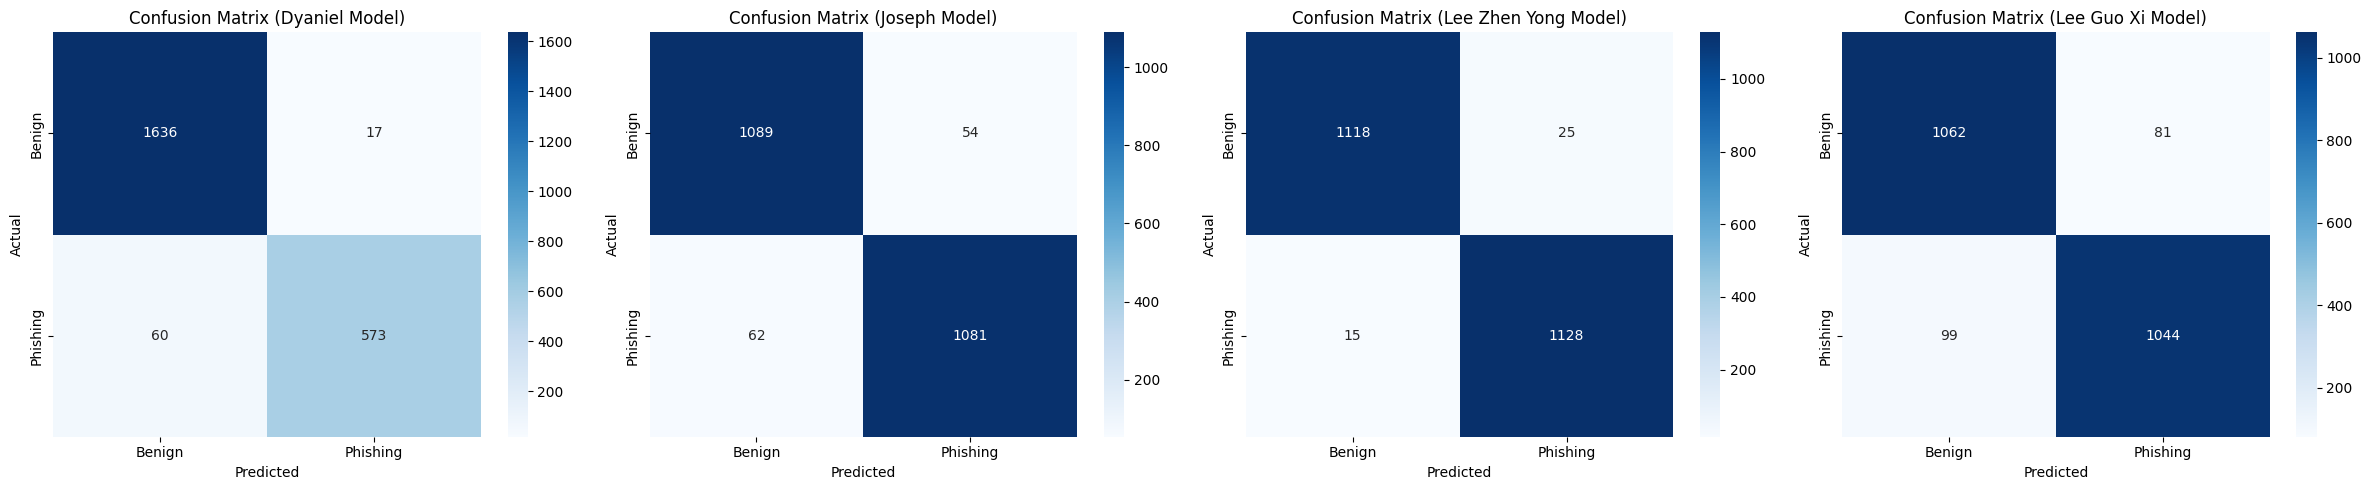

In [ ]:
# Combined Confusion Matrix
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# Dyaniel Model Confusion Matrix
cm_dy = confusion_matrix(dy2_y_test, dy_corrected_preds)
sns.heatmap(cm_dy, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"], ax=axes[0])
axes[0].set_title("Confusion Matrix (Dyaniel Model)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Joseph Model Confusion Matrix
cm_js = confusion_matrix(js2_y_test, js_corrected_preds)
sns.heatmap(cm_js, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"], ax=axes[1])
axes[1].set_title("Confusion Matrix (Joseph Model)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Lee Zhen Yong Model Confusion Matrix
cm_zy = confusion_matrix(zy_y_test_, zy_y_scores)
sns.heatmap(cm_zy, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"], ax=axes[2])
axes[2].set_title("Confusion Matrix (Lee Zhen Yong Model)")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")


# Lee Guo Xi Model Confusion Matrix (LSTM)
cm_gx = confusion_matrix(gx_y_test, gx_y_scores)
sns.heatmap(cm_gx, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"], ax=axes[3])
axes[3].set_title("Confusion Matrix (Lee Guo Xi Model)")
axes[3].set_xlabel("Predicted")
axes[3].set_ylabel("Actual")


plt.tight_layout()
plt.show()

## ROC-AUC Curve

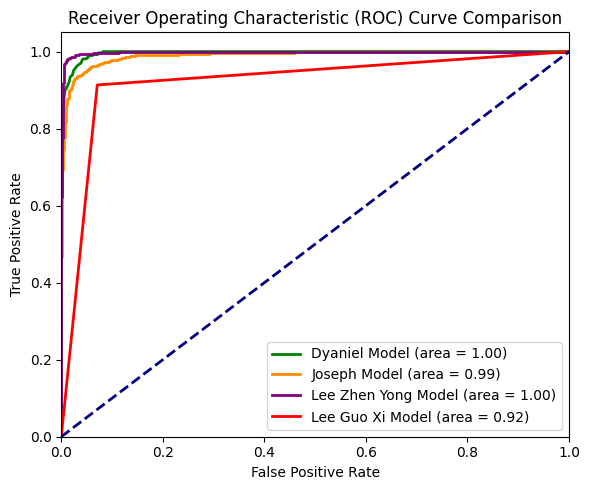

In [ ]:
# Combined ROC Curve
plt.figure(figsize=(6, 5))

# Dyaniel Model ROC Curve
if hasattr(bias_corrector, "predict_proba"):
    dy_y_scores = bias_corrector.predict_proba(dy2_X_test)[:, 1]
    dy_roc_auc = roc_auc_score(dy2_y_test, dy_y_scores)
    fpr_dy, tpr_dy, thresholds_dy = roc_curve(dy2_y_test, dy_y_scores)
    plt.plot(fpr_dy, tpr_dy, color='green', lw=2, label=f'Dyaniel Model (area = {dy_roc_auc:.2f})')
else:
    print("ROC curve for Dyaniel Model cannot be plotted as the model does not have 'predict_proba'.")

# Joseph Model ROC Curve
js_y_scores = svm_model.decision_function(js2_X_test)
js_roc_auc = roc_auc_score(js2_y_test, js_y_scores)
fpr_js, tpr_js, thresholds_js = roc_curve(js2_y_test, js_y_scores)
plt.plot(fpr_js, tpr_js, color='darkorange', lw=2, label=f'Joseph Model (area = {js_roc_auc:.2f})')

# Lee Zhen Yong Model ROC Curve
zy_roc_auc = roc_auc_score(zy_y_test_, test_proba_lr)
fpr_zy, tpr_zy, thresholds_zy = roc_curve(zy_y_test_, test_proba_lr)
plt.plot(fpr_zy, tpr_zy, color='purple', lw=2, label=f'Lee Zhen Yong Model (area = {zy_roc_auc:.2f})')

# Lee Guo Xi Model ROC Curve (LSTM)、
gx_y_scores = (y_proba >= 0.5).astype(int)
gx_roc_auc = roc_auc_score(gx_y_test, gx_y_scores)
fpr_gx, tpr_gx, thresholds_gx = roc_curve(gx_y_test, gx_y_scores)
plt.plot(fpr_gx, tpr_gx, color='red', lw=2, label=f'Lee Guo Xi Model (area = {gx_roc_auc:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Metrics Comparison

In [ ]:
# Create a dictionary to store the metrics
metrics_data = {
    'Model': ['Dyaniel Model', 'Joseph Model', 'Lee Zhen Yong Model', 'Lee Guo Xi Model'],
    'Accuracy': [dy_accuracy, js_accuracy, zy_accuracy, gx_accuracy],
    'Precision': [precision, js_precision, zy_precision, gx_precision],
    'Recall': [recall, js_recall, zy_recall, gx_recall],
    'F1-Score': [dy_f1, js_f1, zy_f1, gx_f1],
    'Training Time (min)': [dy_training_time, js_training_time, zy_training_time, gx_training_time],
    'Prediction Time (ms)': [dy_prediction_time, js_prediction_time, zy_prediction_time, gx_prediction_time]
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
display(metrics_df)

,Model,Accuracy,Precision,Recall,F1-Score,Training Time (min),Prediction Time (ms)
0,Dyaniel Model,0.966317,0.966440,0.966317,0.965941,3.5741,43.4196
1,Joseph Model,0.949256,0.952423,0.945757,0.949078,4.1612,2.0220
2,Lee Zhen Yong Model,0.982578,0.978317,0.986877,0.982578,8.8323,0.1647
3,Lee Guo Xi Model,0.921260,0.928000,0.913386,0.920635,9.4390,3.3011


# Extracting Weights for Keras Models (RNN, CNN, LSTM)

In [ ]:
import os
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Define the destination directory in Drive
destination_dir = '/content/drive/MyDrive/Colab Notebooks/DLI_Assm/'

# Extract Dyaniel RNN Model
dy_rnn_weight_path = os.path.join(destination_dir, 'TP065406.weights.h5')
RNN_model.save_weights(dy_rnn_weight_path)
print(f"Dyaniel RNN model weights saved to '{dy_rnn_weight_path}'")

# Extract Joseph CNN Model
js_cnn_weight_path = os.path.join(destination_dir, 'TP063370.weights.h5')
CNN_model.save_weights(js_cnn_weight_path)
print(f"Joseph CNN model weights saved to '{js_cnn_weight_path}'")

# Extract Zhen Yong CNN Feature Extractor Model
zy_cnn_weight_path = os.path.join(destination_dir, 'TP065016.weights.h5')
cnn_model.save_weights(zy_cnn_weight_path)
print(f"Zhen Yong CNN feature extractor model weights saved to '{zy_cnn_weight_path}'")

# Extract GuoXi LSTM Model
guoxi_lstm_weight_path = os.path.join(destination_dir, 'TP065990.weights.h5')
model.save_weights(guoxi_lstm_weight_path)
print(f"Guo Xi LSTM model weights saved to '{guoxi_lstm_weight_path}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dyaniel RNN model weights saved to '/content/drive/MyDrive/Colab Notebooks/DLI_Assm/TP065406.weights.h5'
Joseph CNN model weights saved to '/content/drive/MyDrive/Colab Notebooks/DLI_Assm/TP063370.weights.h5'
Zhen Yong CNN feature extractor model weights saved to '/content/drive/MyDrive/Colab Notebooks/DLI_Assm/TP065016.weights.h5'
Guo Xi LSTM model weights saved to '/content/drive/MyDrive/Colab Notebooks/DLI_Assm/TP065990.weights.h5'
